## Contents:

* [Introduction](#intro)

* [Exploratory Data Analysis](#eda)
    
    * [Date Feature](#eda1)
    
        * [Extract Time and Date from From_Date Feature](#eda1.1)

        * [Extract Hour from Time](#eda1.2)

    * [Class Label : Incident Type Description](#eda2)
    
    * [Recoding Districts with its actual names](#eda3)
    
    * [Extracting Latitude and Longitiude features from the location feature](#eda4)
    
    * [Check for Missing Values](#eda5)
    
    * [Is there a seasonal influence on the crimes?](#eda6)
    
        * [Does the crime distribution vary over the months?](#eda6.1)
        
    * [Does the crime distribution/count vary over the days of the week?](#eda7)
    
    * [Does the crime distribution/count vary over the different hours?](#eda8)
    
        * [ Is there is a significant difference in larceny related crimes during the peak hours of 16,17,18 between the Weeekends and Weekdays?](#eda8.1)
    
    * [Are there any districts which have more propensity of crime happening than the rest?](#eda9)
    
    * [Are there any hot spots in Boston for different crimes?](#eda10)
    
    * [Have the crimes/distribution increased over the years?](#eda11)
    
    * [How is the shooting crime scene in Boston?](#eda12)
    
    * [How are the crimes distributed across streets?](#eda13)
    
        * [Reasons behind Washington Street having high number of crimes](#eda13.1)
        
        * [Boston Marathon Bombings?](#eda13.2)
        
        * [Effect of Boston July 4 event on crime related incidents over the years](#eda13.3)
    
    * [Crime Specific Analysis](#eda14)
        
        * [Idenitifying hotspots for White-Collar crimes](#eda14.1)
        
        * [Identifying hostpots for Fare Evasions](#eda14.2)
        
        * [ Identifying hotspots for Motor Vehicle Accidents](#eda14.3)
        
        * [Idenifying hotspots for Aircraft related crimes](#eda14.4)
        
        * [Identifying hotspots for Hate Crimes](#eda14.5)
        
        * [Identifying hotspots for Prostitution](#eda14.6)
        
        * [Identifying hotspots for Pub-Alchol related crimes](#eda14.7)
        
    * [Handle missing values](#eda15)

<a id='intro'></a>

## Introduction

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

<a id='eda'></a>

## Exploratory Data Analysis

#### Load data

In [2]:
df_boston = pd.read_csv('Crime_Incident_Reports.csv')

/cise/homes/keshav/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(df_boston)

268056

In [4]:
df_boston.columns = [u'compnos', u'naturecode', u'incident_type_description',
       u'main_crimecode', u'reptdistrict', u'reporting_area', u'from_date',
       u'weapon_type', u'shooting', u'domestic', u'shift_incident', u'year', u'month',
       u'day_week', u'ucrpart', u'x', u'y', u'streetname', u'xstreetname',
       u'location']

** From the features present, only the features relevant to the class label are taken. **

In [5]:
relevant_features = [u'incident_type_description', u'reptdistrict', u'from_date',
       u'weapon_type', u'shooting', u'year', u'month',
       u'day_week', u'streetname',u'location']

In [6]:
df_boston = df_boston[relevant_features]

<a id='eda1'></a>

### Date Feature

<a id='eda1.1'></a>

#### Extract Time and Date from From_Date Feature

In [7]:
list_times = list()
list_dates = list()
for row in df_boston.from_date:
    list_dates.append(row.split(' ',1)[0])
    list_times.append(row.split(' ',1)[1])
df_boston['dates'] = pd.Series(list_dates)
df_boston['times'] = pd.Series(list_times)

<a id='eda1.2'></a>

#### Extract Hour from Time

In [8]:
list_hours = [int(row.split(':',1)[0]) if 'AM' in row else int(row.split(':',1)[0]) + 12 for row in df_boston.times]
df_boston['hours'] = list_hours
df_boston = df_boston.drop(['from_date','times'],1)

<a id='eda2'></a>

### Class Label : Incident Type Description

The different types of crimes are preprocessed and grouped into smaller categories by combining similar crimes and 
stem versions of the same crime,

#### Grouping crimes

In [9]:
list_crimes_upper = [row.upper() for row in df_boston.incident_type_description]
df_boston['crime_category'] = list_crimes_upper
df_boston = df_boston.drop('incident_type_description',1)

In [10]:
crime_group_map = {
    'RESIDENTIAL BURGLARY' :'BURGLARY','BURGTOOLS':'BURGLARY','OTHER BURGLARY':'BURGLARY','COMMERCIAL BURGLARY':'BURGLARY', 'OTHER BURGLARY':'BURGLARY', 
 
    'SIMPLE ASSAULT':'OTHER ASSAULTS', 'INDECENT ASSAULT':'OTHER ASSAULTS', 
    
    'BENOPROP' :'PROPERTY','PROPERTY RELATED DAMAGE':'PROPERTY', 'PROPERTY LOST':'PROPERTY','RECOVERED STOLEN PROPERTY':'PROPERTY','INVESTIGATE PROPERTY':'PROPERTY', 'STOLEN PROPERTY CHARGES':'PROPERTY', 'PROPFOUND':'PROPERTY',  'PROPDAM':'PROPERTY',  'PROPERTY FOUND':'PROPERTY', 'PROPLOST':'PROPERTY', 'INVPROP':'PROPERTY',                                                                            
     
    'VAL' :'AUTO VIOLATIONS', 'TOWED':'AUTO VIOLATIONS', 'LICENSE PLATE RELATED INCIDENTS':'AUTO VIOLATIONS', 'MOTOR VEHICLE ACCIDENT RESPONSE':'AUTO VIOLATIONS',  'LICENSE VIOLATION':'AUTO VIOLATIONS', 'AUTO THEFT RECOVERY':'AUTO VIOLATIONS', 'LICVIOL':'AUTO VIOLATIONS',
        
     'FRAUD':'WHITE-COLLAR', 'EMBEZELLEMENT':'WHITE-COLLAR', 'FORGERY':'WHITE-COLLAR', 'COUNTERFEITING':'WHITE-COLLAR',
    
    'EMBEZZLEMENT':'WHITE-COLLAR','EMBEZELLMENT':'WHITE-COLLAR' ,
    
    'LIQUOR VIOLATION':'VIOLATION OF LIQUOR LAWS','VIOLATION OF LIQUOR LAWS':'VIOLATION OF LIQUOR LAWS',
    
    'CRIMES AGAINST CHILDREN':'CRIMES AGAINST CHILDREN', 'OFFENSES AGAINST CHILD/FAMILY': 'CRIMES AGAINST CHILDREN',
    
    'EVADING FARE':'EVADING FARE', 'SKIP FARE':'EVADING FARE',
    
    'SEXREG':'SEX OFFENCES', 'SEX OFFENDER REGISTRATION':'SEX OFFENCES', 'RAPE AND ATTEMPTED':'SEX OFFENCES',
    
    'HATECRIM':'HATE CRIME',
    
    'PROSTITUTION CHARGES':'PROSTITUTION', 'PROSTITUTION':'PROSTITUTION',
    
    'AIRCRAFT' :'AIRCRAFT', 
     
     'HARBOR RELATED INCIDENTS':'HARBOR', 'HARBOR':'HARBOR', 
    
    'FIREARM VIOLATIONS':'FIREARM VIOLATIONS','FIREARM DISCOVERY':'FIREARM VIOLATIONS', '32GUN' :'FIREARM VIOLATIONS', 'BALLISTICS' :'FIREARM VIOLATIONS', 'BALLIST':'FIREARM VIOLATIONS',
    
    'DRUG VIOLATION':'DRUG CHARGES', 
    
    'MEDASSIST':'MEDICAL ASSISTANCE' ,
    
    'HAZARDOUS':'BIOTHREAT',
    
    'FIRE':'FIRE RELATED REPORTS',
    
    'PRISON': 'PRISONER RELATED INCIDENTS'  
    }
    

In [11]:
list_crimes = list(df_boston.crime_category.values)
list_group_crimes = [crime_group_map[crime] if crime in crime_group_map else crime for crime in list_crimes ]
df_boston.crime_category = list_group_crimes

<a id='eda3'></a>

### Recoding Districts with its actual names

In [12]:
district_code_name_map = {
'A1' : 'Downtown','A15' : 'Charlestown','A7' :'East Boston',
'B2' : 'Roxbury',
'B3' : 'Mattapan',
'C6' : 'South Boston',
'C11' : 'Dorchester',
'D4' : 'South End',
'D14' : 'Brighton',
'E5' :'West Roxbury',
'E13' : 'Jamaica Plain',
'E18': 'Hyde Park',
'HTU': 'Human Traffic Unit'
}
list_districts = list(df_boston.reptdistrict.values)
recoded_districts_list = [district_code_name_map[district] if district in district_code_name_map else district for district in list_districts]
df_boston['recoded_districts'] = recoded_districts_list
df_boston = df_boston.drop('reptdistrict',1)

<a id='eda4'></a>

### Extracting Latitude and Longitiude features from the location feature

In [13]:
list_lattitudes = list()
list_longitudes = list()
for loc in df_boston.location.value_counts().index:
    list_lattitudes.append(float(loc.strip('()').split(',')[0]))
    list_longitudes.append(float(loc.strip('()').split(',')[1]))
df_boston['latitudes'] = pd.Series(list_lattitudes)
df_boston['longitudes'] = pd.Series(list_longitudes)

In [14]:
df_boston = df_boston.drop('location',1)

<a id='eda5'></a>

### Check for Missing Values

In [15]:
df_boston.apply(lambda x: sum(x.isnull())/float(len(df_boston)),axis=0) 

weapon_type          0.000000
shooting             0.000000
year                 0.000000
month                0.000000
day_week             0.000000
streetname           0.000873
dates                0.000000
hours                0.000000
crime_category       0.000000
recoded_districts    0.001332
latitudes            0.913455
longitudes           0.913455
dtype: float64

<a id='eda6'></a>

### Is there a seasonal influence on the crimes?

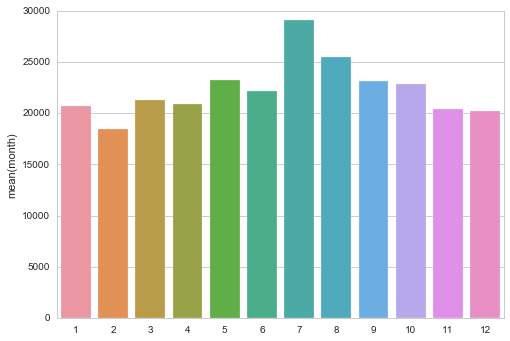

In [19]:
sns.barplot(x = df_boston.month.value_counts().index, y = df_boston.month.value_counts())

* The incidents seem to reach a peak during the month of July and has a low during February. This could be attributed to the seasonal influence. 
* It seems logical that less people will be out less during the cold months (which notice a relative dip in attacks) when compared to the rest of the months. 
* Also Summer in Boston attracts great number of tourists - especially from June to August. The July 4 for exmaple. seems to be a popular event attracting huge amount of people outside - thus great chance of thefts and other crimes happening.

<a id='eda6.1'></a>

#### Does the crime distribution vary over the months?

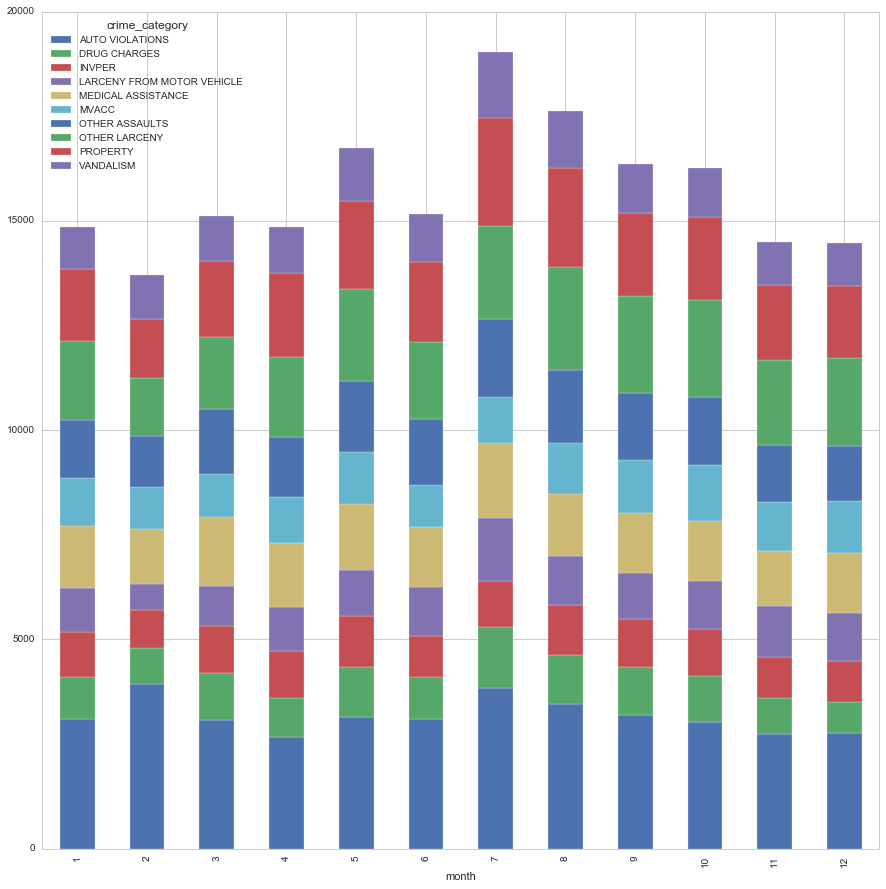

In [24]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['month','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='month',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

* Auto Violations followed by Property seem to occur the most during the months of July. 
* The rise in property related crimes correlates with the fact that more people will be out during this month.

** The BPD could allocate more of their resources during the summer months, especially in crowded places to avoid
property related crimes and thefts. **

In [25]:
sum(df_boston.crime_category.value_counts()[:10])/float(len(df_boston))

0.70376712328767121

** 70 % of the crimes happens within the top ten crimes. t is better for the police to concentrate their policing more on these crimes and work towards controlling them. ** 

<a id='eda7'></a>

### Does the crime distribution/count vary over the days of the week?

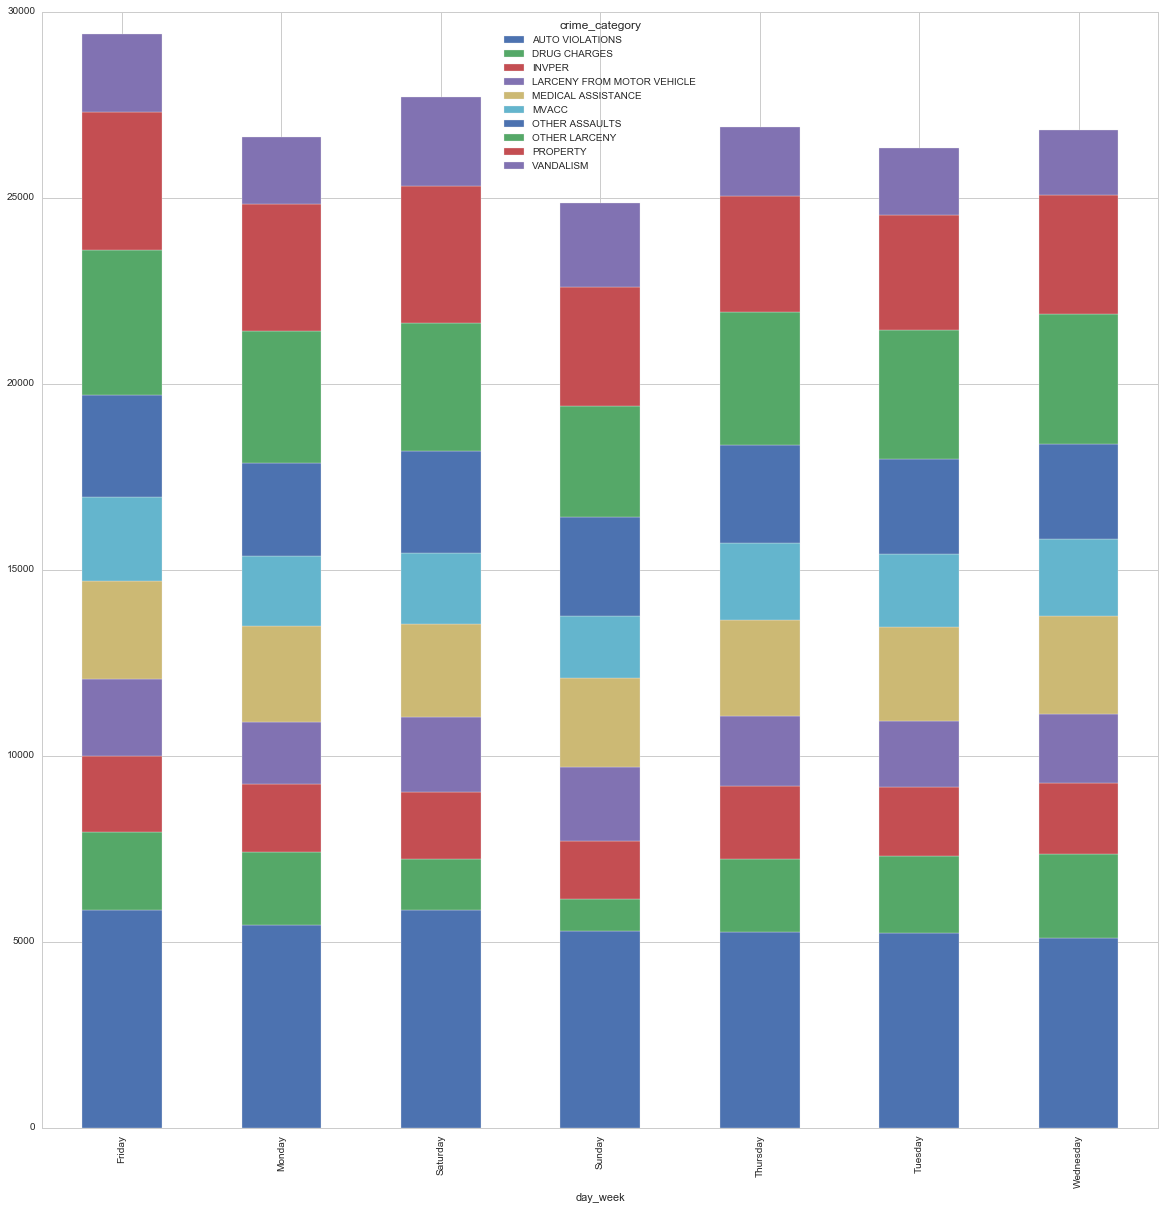

In [26]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['day_week','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='day_week',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(20,20))
tmp.plot(ax=axes,kind='bar', stacked=True)

** Friday registers the most number of crimes while the least amount of incidents take place on Sunday. The proportion of crimes seem to be the same. ** 

<a id='eda8'></a>

### Does the crime distribution/count vary over the different hours?

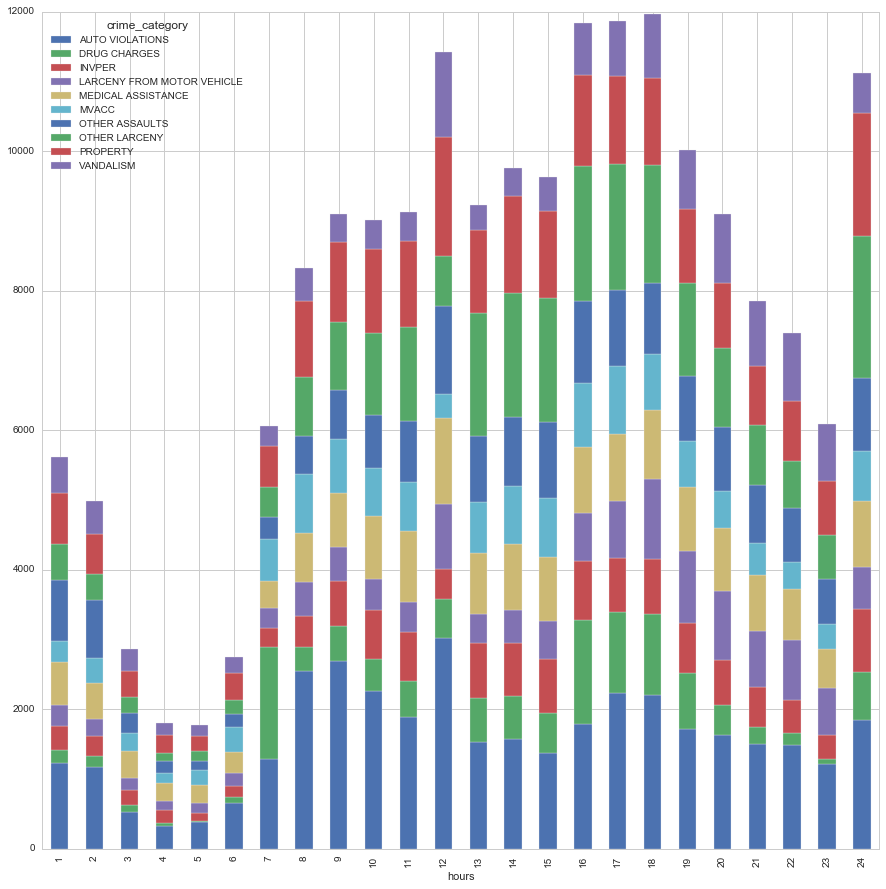

In [27]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['hours','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='hours',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

* The major peaks of this distribution occur during the hours 16-18 and during the 12th and 24th hours. 


* The times entered for a large part of crimes seem to be a rough estimate - 12 AM/PM seem to be an easy default option - this could be a reason behind the abnormally large peaks of the 12th and 24th hours - especially subsequent hours for each;the 13th and 1st hours seem to differ by a large amount.


* Also, the 16-18 hours are the rush peak hours in Boston as the day gets over - the large rush of people in the public transport(The T). The largest proportion of crimes seem to be that of Vandalism, Drug Charges and Larceny - not surprising since there is a good chance of them happening while travelling during the commotion/large crowds and the trains getting damaged(more info is needed though - just a hypothesis).


* The proportion of drug charges seem to be abnormally high in the 7th hour - possibly this is when they get recorded by BPD for including all the early morning hours?


* The Auto violations seem to have a distinct increase in the 12th hour when compared to the rest - could be either
    due to lunch time and hence more vehicles outside or a default entry when the precise time is not known.

<a id='eda8.1'></a>

#### Is there is a significant difference in larceny related crimes during the peak hours of 16,17,18 between the Weeekends and Weekdays?

In [29]:
df_evening_hours = df_boston.query('hours == 16 or hours == 17 or hours == 18')
df_evening_weekday = df_evening_hours.query('day_week != "Saturday" and day_week!= "Sunday"')
df_evening_weekday_larceny = df_evening_weekday.query('crime_category == "OTHER LARCENY"')
df_evening_weekday_larceny_count = pd.DataFrame(df_evening_weekday_larceny.groupby('day_week')['crime_category'].count())

In [30]:
df_evening_hours = df_boston.query('hours == 16 or hours == 17 or hours == 18')
df_evening_weekend = df_evening_hours.query('day_week == "Saturday" or day_week== "Sunday"')
df_evening_weekend_larceny = df_evening_weekend.query('crime_category == "OTHER LARCENY"')
df_evening_weekend_larceny_count = pd.DataFrame(df_evening_weekend_larceny.groupby('day_week')['crime_category'].count())

In [31]:
df_evening_weekend_larceny_count['day_type'] = ['Weekend'] * 2
df_evening_weekday_larceny_count['day_type'] = ['Weekday'] * 5
df_larceny_weekday_weekend = df_evening_weekend_larceny_count.append(df_evening_weekday_larceny_count)

/cise/homes/keshav/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


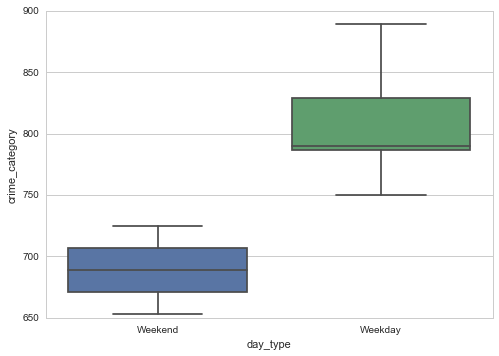

In [32]:
sns.boxplot(df_larceny_weekday_weekend.crime_category, groupby=df_larceny_weekday_weekend['day_type'])

In [33]:
from scipy.stats import ttest_ind
weekday = df_larceny_weekday_weekend.query('day_type == "Weekday"')
weekend = df_larceny_weekday_weekend.query('day_type == "Weekend"')
ttest_ind(weekday['crime_category'], weekend['crime_category'])

Ttest_indResult(statistic=2.7382420090235371, pvalue=0.040877424250545913)

**On account of the box plots shown and the associated p value with its difference in means, there seems to be a strong evidence that the apparent significant difference between the 2 groups is not due to chance.**

** The police can increase patrolling during the evening weekdays and take some measures to reduce the rate of larceny incidents. **

In [20]:
df_boston['weekday_weekend'] = df_boston.day_week.apply(lambda x: 0 if (x!='Saturday' and x!='Sunday') else 1)

In [21]:
df_boston.weekday_weekend.value_counts()

0    195217
1     72839
Name: weekday_weekend, dtype: int64

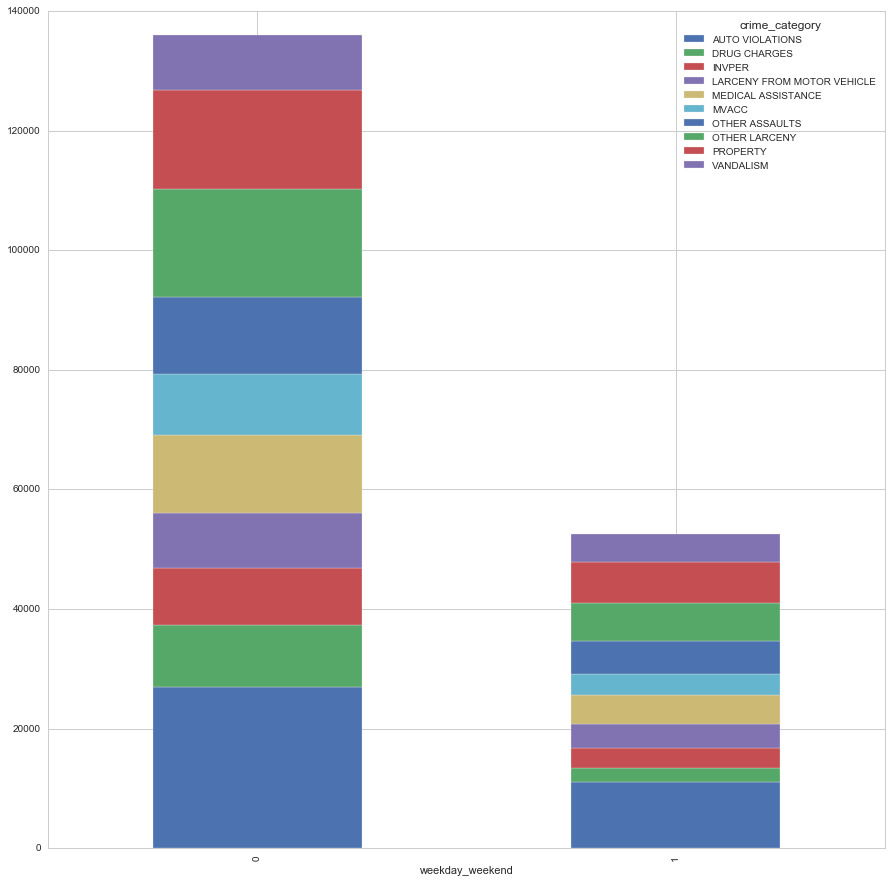

In [47]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['weekday_weekend','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='weekday_weekend',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

**The crime distirubtion seems to be similar whether it's a weekend or not. **

<a id='eda9'></a>

### Are there any districts which have more propensity of crime happening than the rest?

In [22]:
df_boston['district'] = df_boston.recoded_districts
df_boston = df_boston.drop('recoded_districts',1)

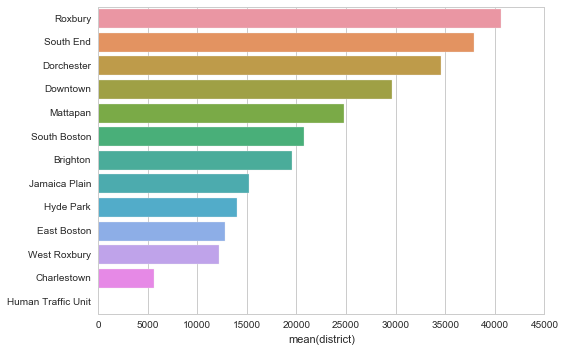

In [36]:
sns.barplot(y = df_boston.district.value_counts()[:20].index, x = df_boston.district.value_counts()[:20])

Roxbury seems to be the district with the maximum number of crime incidents, while Charlestown seems to have less prone to crime incidents. 

* ** More focus can be given to the districts on the upper end of the distribution in areas like Roxbury, South End and Dorchester. ** 
* ** Possible steps - putting extra patrol, increase in beat officers etc. **

<a id='eda10'></a>

### Are there any hot spots in Boston for different crimes?

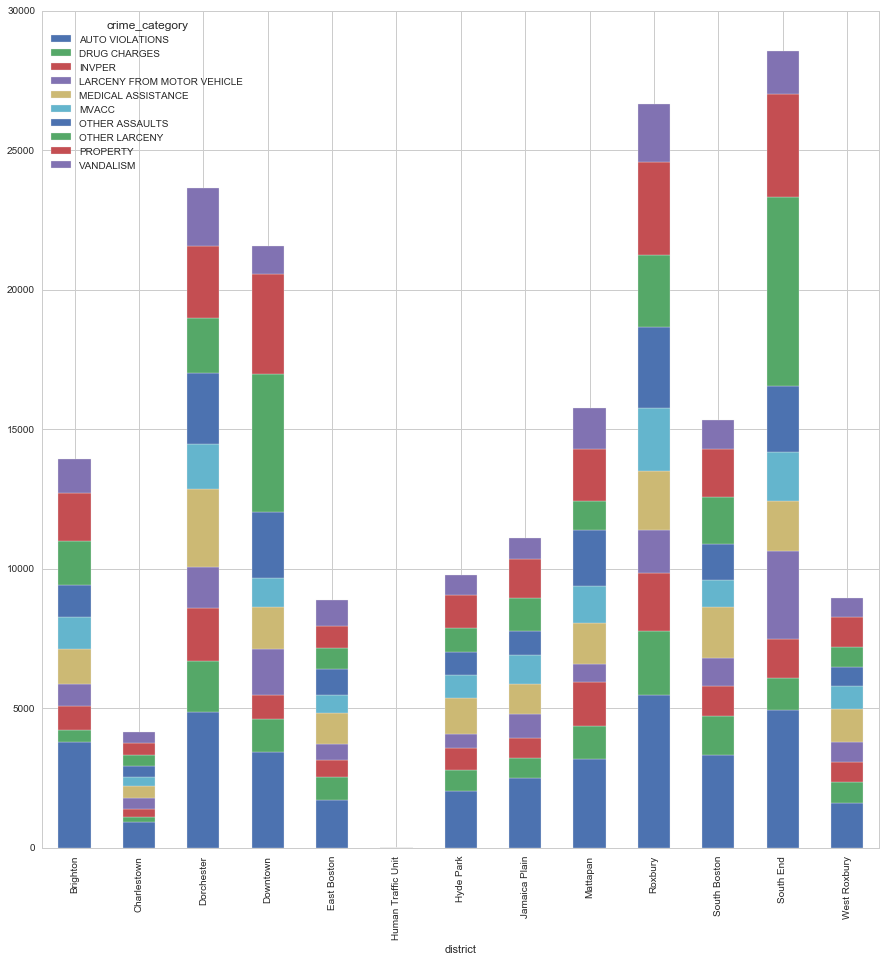

In [37]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['district','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='district',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

* There seems to be a high proportion of Larceny-incidents in the case of South End - The South End has two most frequented T stop- Prudential and Copley which could contribute to the high larceny incidents apart from the high amount of tourists and vehicles in this area.


* The drug related incidents seem to have their maximum count in Downtown while assualt related incidents are represented by Dorchester, Roxbury, Downtown and South End the most.

<a id='eda11'></a>

### Have the crimes/distribution increased over the years?

#### Range of times

In [149]:
from datetime import datetime
list_date_objects = list()
for date in df_boston.dates:
    list_date_objects.append(datetime.strptime(date, '%m/%d/%Y'))

In [150]:
min(list_date_objects)

datetime.datetime(2012, 7, 8, 0, 0)

In [151]:
max(list_date_objects)

datetime.datetime(2015, 8, 10, 0, 0)

The dataset has been collected from 8 July 2012 to 10 August 2015 - for a period of 3 years.

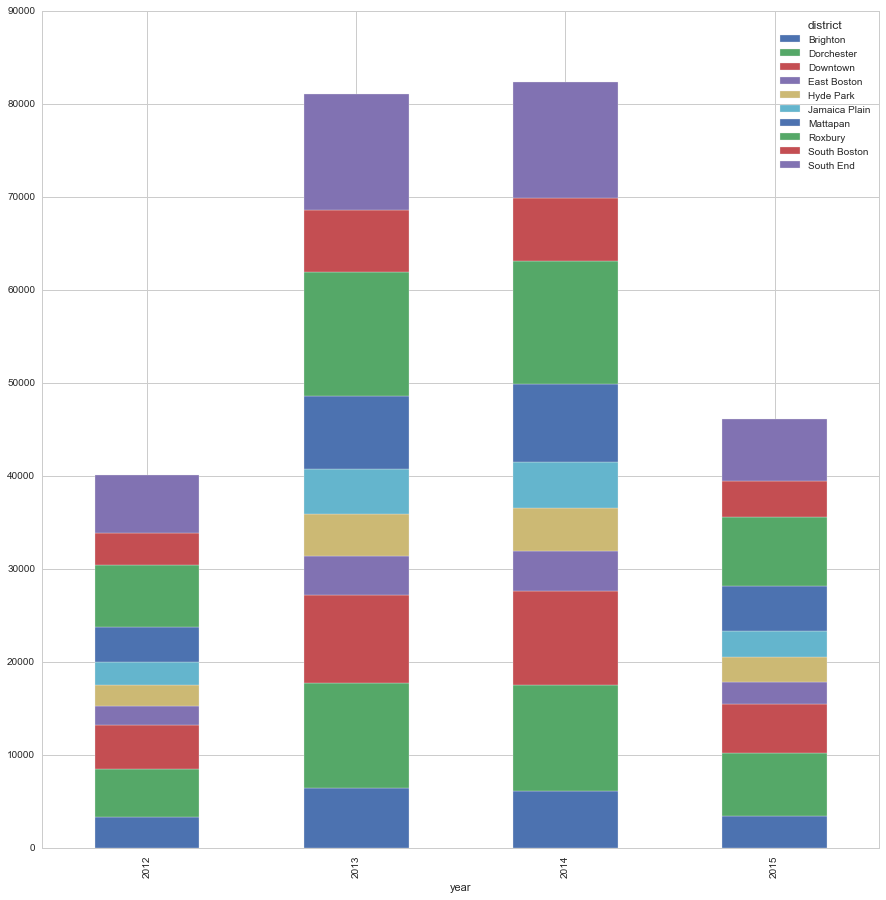

In [152]:
df_crime=pd.DataFrame(df_boston.district.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['district'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['year','district']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='year',columns='district',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

** There seems to be no apparent increase in crime rate in the districts over the years. **

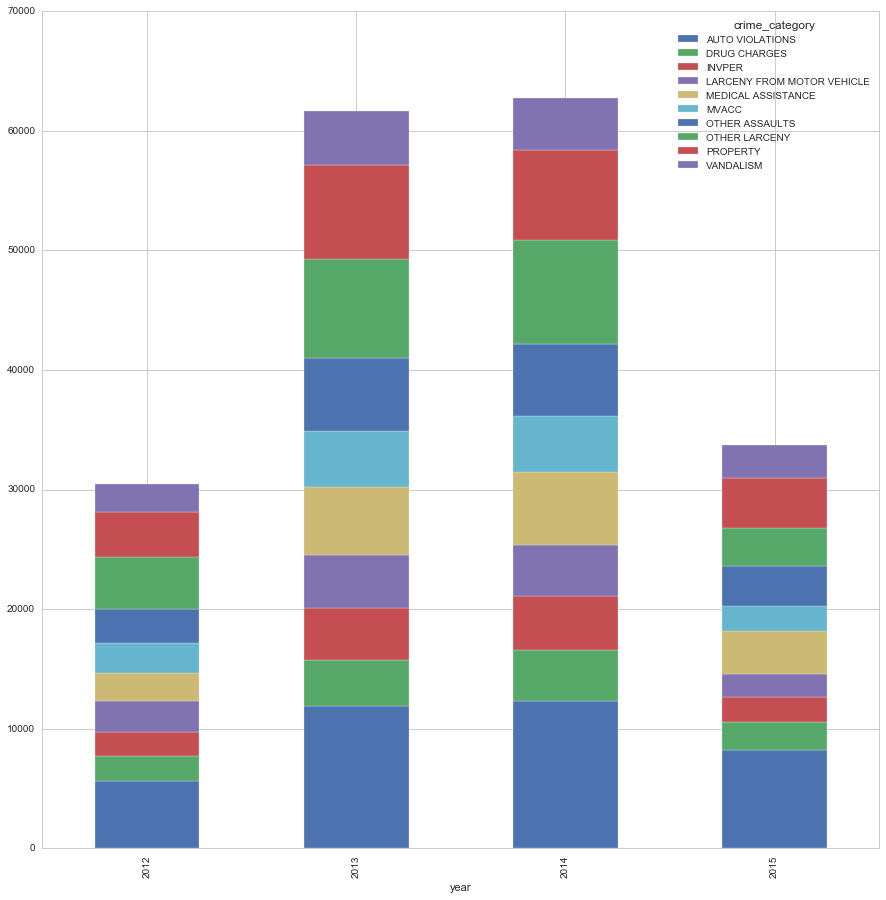

In [154]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['year','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='year',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

** There seem to no apparent increase in the crime distribution(top 10) over the years. **

<a id='eda12'></a>

### How is the shooting crime scene in Boston?

In [140]:
df_boston.shooting.value_counts()

No     267359
Yes       697
Name: shooting, dtype: int64

** There seem to be a very less number of shooting incidents that have been registered over the last 3 years. **

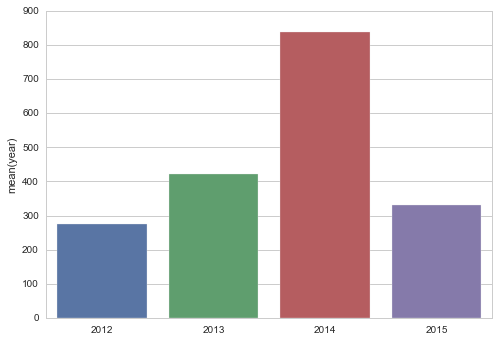

In [147]:
df_firearm = df_boston.query("crime_category == 'FIREARM VIOLATIONS'")
sns.barplot(y = df_firearm.year.value_counts(), x = df_firearm.year.value_counts().index)

* The number of firearm incidents/crimes seem to have increased in 2014 compared to previous years. 

* **This can be attributed to the BPD's increased gun focus in 2014 as compared to 2013. **
See: https://www.bostonglobe.com/metro/2014/12/30/homicides-spiked-boston-reversing-trend/UzyeyWzCmczTHxXd0Bd03J/story.html

<a id='eda13'></a>

### How are the crimes distributed across streets?

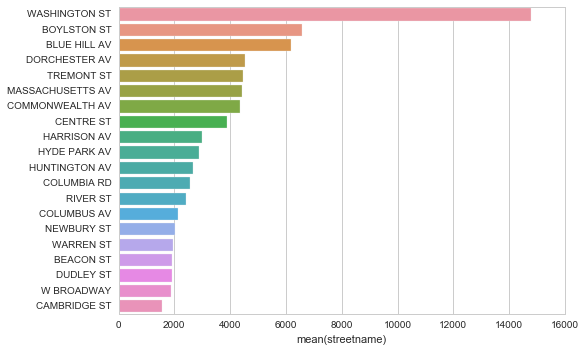

In [181]:
sns.barplot(y = df_boston.streetname.value_counts()[:20].index, x = df_boston.streetname.value_counts()[:20])

Washington Street seems to be the street where a large proportion of crimes have occured, followed by Boylston Street and 
Blue Hill Ave.

In [182]:
df_washington_st = df_boston.query('streetname == "WASHINGTON ST"')

In [183]:
df_washington_st.district.value_counts()

Roxbury               3269
Downtown              2598
Dorchester            2194
Jamaica Plain         1772
West Roxbury          1688
Brighton              1496
South End             1405
Hyde Park               79
Charlestown             51
Mattapan                40
South Boston             6
Human Traffic Unit       1
East Boston              1
Name: district, dtype: int64

<a id='eda13.1'></a>

#### Reasons behind Washington Street having high number of crimes (source:Wikipedia)
* There are multiple Washington Streets situated in Boston - One of them is the longest street in Boston 
originating in downtown Boston, Massachusetts that extends southwestward to the Massachusetts-Rhode Island state line. 
* There are other two significant and two minor streets in Boston with the same name.
In the Dorchester neighborhood, Washington Street extends approximately 2.8 miles (4.5 km) from Blue Hill Avenue near Geneva Avenue to Dorchester Avenue at the southern boundary of the city.
- In Allston-Brighton, Washington Street begins at the boundary with Brookline and extends about 2 miles (3.2 km) to the boundary with Newton near Burton Street. As a whole, it begins in Brookline Village, and crosses Brookline, Allston, Brighton, Newton, and Wellesley, ending at Wellesley's boundary with Natick, a total of almost 13.5 miles (21.7 km). It is the main east-west street in Brighton.
- In Hyde Park, Washington Street extends approximately seven blocks in the small portion of Hyde Park on the east side of the Neponset River.
- In Charlestown, Washington Street begins at a dead end near the intersection of Austin Street and New Rutherford Avenue and extends three blocks to Harvard Street. This is two blocks from the north end of the Charlestown Bridge and three blocks from the beginning of the Washington Street that is the subject of this article.

In [184]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]
tmp=pd.DataFrame(df_crime_head_10.groupby(['streetname','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='streetname',columns='crime_category',values='count')
tmp.fillna(0);

In [185]:
tmp = tmp.query('index == "WASHINGTON ST" or index == "BOYLSTON ST" or index == "BLUE HILL AV" or index == "DORCHESTER AV" or index == "TREMONT ST"')

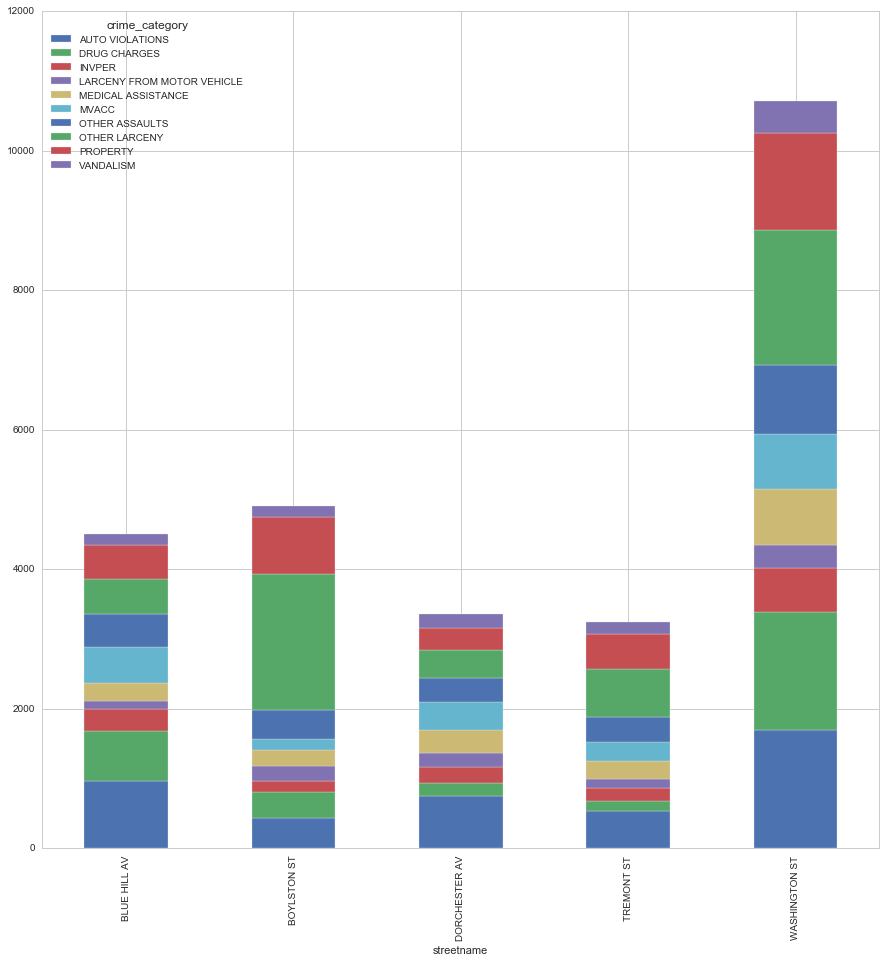

In [186]:
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

** The crime distribution seem to vary to a certain extent across the streets. **

<a id='eda13.2'></a>

#### Boston Marathon Bombings?

In [187]:
df_boylston = df_boston.query('streetname == "BOYLSTON ST"')

In [188]:
df_boylston_bomb = df_boylston.query('dates == "04/15/2013"')

In [189]:
df_boylston_bomb.crime_category.value_counts()

PROPERTY                      98
MEDICAL ASSISTANCE            17
AGGRAVATED ASSAULT             3
DEATH INVESTIGATION            3
LARCENY FROM MOTOR VEHICLE     1
OTHER LARCENY                  1
FIRE RELATED REPORTS           1
Name: crime_category, dtype: int64

We can see the effect of Boston Marathon Bombings on Boylston Street - the epicentre of the bombings. 98 incidents are related to property related crimes and there seem to be some medical assistance related incidents too.

#### Effect of Boston Marathon on crime related incidents over the years:

In [190]:
df_boston_marathon = df_boston.query('dates == "04/15/2013" or dates == "04/16/2012" or dates == "04/21/2014" or dates == "04/20/2015"')

In [191]:
df_boston_marathon.crime_category.value_counts()[:5]

PROPERTY              189
AUTO VIOLATIONS        80
OTHER LARCENY          65
MEDICAL ASSISTANCE     62
WHITE-COLLAR           44
Name: crime_category, dtype: int64

There has been a high amount of Medical Assistance and Property related incidents - both make sense in the case of an event like 
Boston Marathon.

<a id='eda13.3'></a>

#### Effect of Boston July 4 event on crime related incidents over the years

In [193]:
df_boston_marathon = df_boston.query('dates == "07/04/2013" or dates == "07/04/2012" or dates == "07/04/2014" or dates == "07/04/2015"')

In [194]:
df_boston_marathon.crime_category.value_counts()[:5]

AUTO VIOLATIONS       98
PROPERTY              70
OTHER ASSAULTS        53
MEDICAL ASSISTANCE    50
VANDALISM             48
Name: crime_category, dtype: int64

A high number of auto violations and property related crimes have been related - reasonable in the case of a big event like the July 4 Parade.

<a id='eda14'></a>

### Identifying hotspots for specific crimes

<a id='eda14.1'></a>

#### Idenitifying hotspots for White-Collar crimes

* White-collar crimes include those of Fraud, Embezzlement and Forgery. These crimes are typical to occur in regular commercial environments and less in residential neighbourhoods. 
* Identifying where such crimes occur can be useful for BPD to allocate their monitoring resources more useufully.

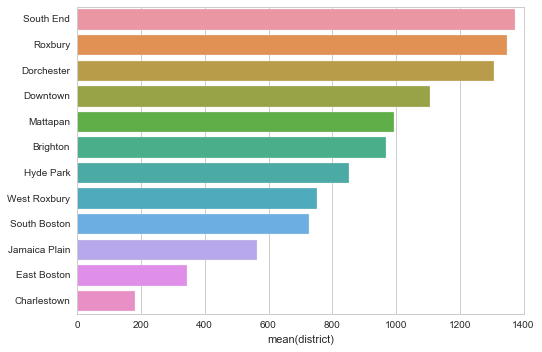

In [198]:
df_white_collar = df_boston.query('crime_category == "WHITE-COLLAR"')
sns.barplot(y = df_white_collar.district.value_counts()[:20].index, x = df_white_collar.district.value_counts()[:20])

* South End seems to have the highest amount of such crime followed by ROxbury and Dorchester. \
* **A closer look at the establishments in South End where such white-collar crimes usually occur can help
    in controlling such crimes.**

<a id='eda14.2'></a>

#### Identifying hostpots for Fare Evasions

* Fare Evasion happens when one skips/avoids paying fares while travelling on public transport.
* The BPD can place more officers in the T stations to watch out for passengers who try to evade paying fares.
* Idenitfying hotspots can help in increasing the focus to such places.

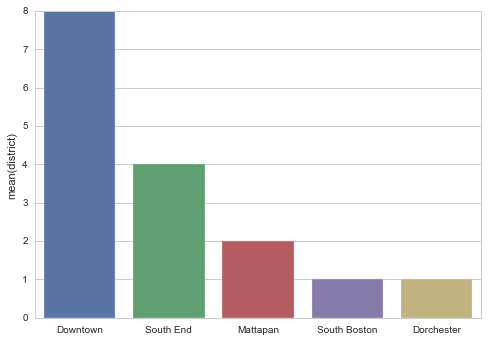

In [203]:
df_fare = df_boston.query('crime_category == "EVADING FARE"')
sns.barplot(x = df_fare.district.value_counts()[:20].index, y = df_fare.district.value_counts()[:20])

* **The downtown area seems to have most frequent cases of fare evasions. THe T stations in the area include
the busy Park Street, Downtown Crossing and South Station. These 3 areas are frequented by a huge amount of passengers
and is prone to more such crimes. **
* **Increasing monitoring efforts at places during the peak hours can help in reducing the crime rate.**

<a id='eda14.3'></a>

#### Identifying hotspots for Motor Vehicle Accidents

* Motorvehicle accidents can be avoided if the hotspots are identified and the traffic BPD can take several
measures to reduce them - easing congestions, stricter speed limits, better road signals.

In [214]:
df_mvacc = df_boston.query("crime_category == 'MVACC'")

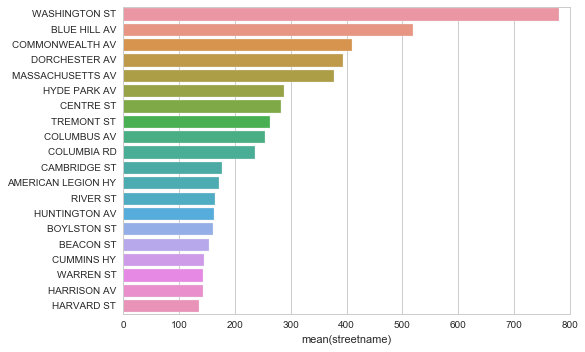

In [215]:
sns.barplot(y = df_mvacc.streetname.value_counts()[:20].index, x = df_mvacc.streetname.value_counts()[:20])

* **One interesting observation is the sudden appearance of Hyde Park Av and Centre Street in the hgih frequency list than their usual overall counts. **
* ** As expected, Washigton Street has the highest count followed by Blue Hill Ave which seems to overtake the Commonwealth which usually is the second most crime-frequent street overall. **
* ** A more detailed look at these streets can help to identify any factors for high accidents. Suitable measures can be taken to reduce them as detailed above. **

<a id='eda14.4'></a>

#### Idenifying hotspots for Aircraft related crimes

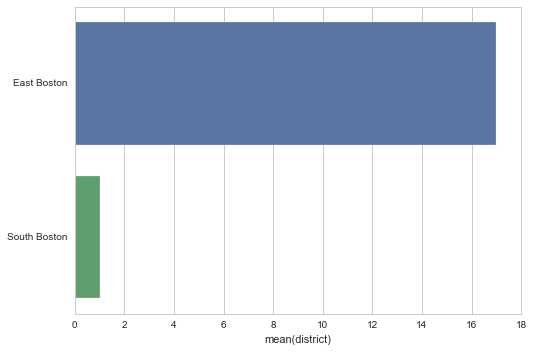

In [217]:
df_air = df_boston.query("crime_category == 'AIRCRAFT'")
sns.barplot(y = df_air.district.value_counts()[:20].index, x = df_air.district.value_counts()[:20])

* A large number of aircraft crimes occur in the East Boston where Boston Logan is situated.

<a id='eda14.5'></a>

#### Identifying hotspots for Hate Crimes

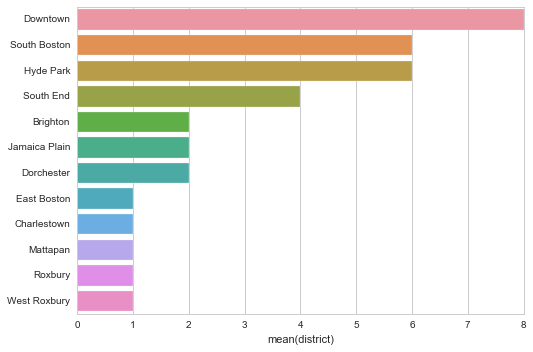

In [218]:
df_hate = df_boston.query("crime_category == 'HATE CRIME'")
sns.barplot(y = df_hate.district.value_counts()[:20].index, x = df_hate.district.value_counts()[:20])

* A large proportion of Hate Crimes occur in Downtown, South Boston and Hyde Park. 
* Knowledge of race/gender density can be useful in analyzing why these crimes occur in these areas.

<a id='eda14.6'></a>

#### Identifying hotspots for Prostitution

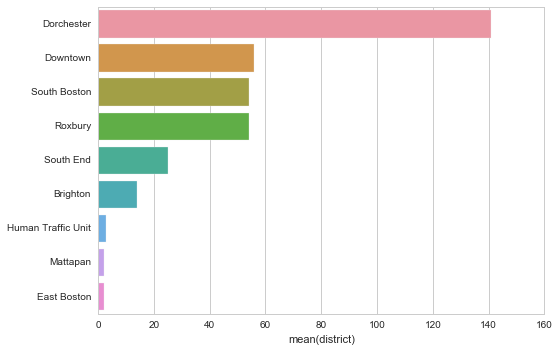

In [220]:
df_prostn = df_boston.query("crime_category == 'PROSTITUTION'")
sns.barplot(y = df_prostn.district.value_counts()[:20].index, x = df_prostn.district.value_counts()[:20])

* Dorchester has the highest realted crimes. Identifying reasons for the crime can help in decreasing the count of 
prostitution related crimes.

<a id='eda14.7'></a>

#### Identifying hotspots for Pub-Alchol related crimes

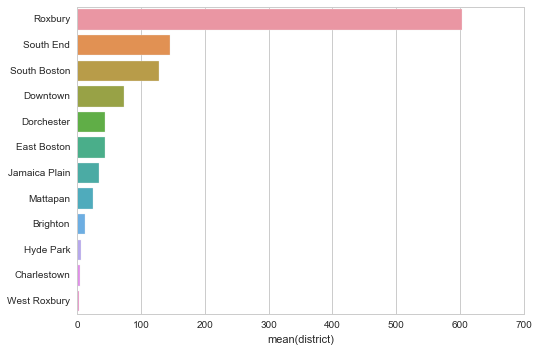

In [221]:
df_pub = df_boston.query("crime_category == 'PUBDRINK'")
sns.barplot(y = df_pub.district.value_counts()[:20].index, x = df_pub.district.value_counts()[:20])

* Roxbury seems to a very high count of such crimes. 
* Identifying pubs which are prone to such crimes can help in decreasing the occurence of such crimes.

<a id='eda15'></a>

In [23]:
df_boston = df_boston.drop(['shooting','dates','weapon_type'],1)

In [25]:
df_boston.apply(lambda x: sum(x.isnull())/float(len(df_boston)),axis=0) 

year                 0.000000
month                0.000000
day_week             0.000000
streetname           0.000873
hours                0.000000
crime_category       0.000000
recoded_districts    0.001332
latitudes            0.000000
longitudes           0.000000
weekday_weekend      0.000000
dtype: float64

The missing values for the district and streetname feature are taken as another class variable - 'missing'. This can
lend some information into the data, than tring to remove them or impute,

#### Missing Values for Districts

In [26]:
df_boston['district'] = df_boston.recoded_districts
df_boston = df_boston.drop('recoded_districts',1)

In [27]:
list_districts = ['missing_district' if str(district) == 'nan' else district for district in df_boston.district]
df_boston.district = list_districts

#### Missing Values for Streetname

In [28]:
list_streets = ['missing_street' if str(street) == 'nan' else street for street in df_boston.streetname]
df_boston.streetname = list_streets

In [3]:
# Save to Pickle

In [29]:
df_boston.to_pickle('df_boston.pkl')